In [102]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/media/beans/ssd/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
run_paths = glob.glob("/media/beans/ssd/blender_membank/*/run*", recursive=True)

In [137]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in range(115, 1160, 116)], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct

aux.shape, targets.shape, run_path

((1160, 5), (1160, 30), '/media/beans/ssd/blender_membank/dataloader_09/run_1')

In [138]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

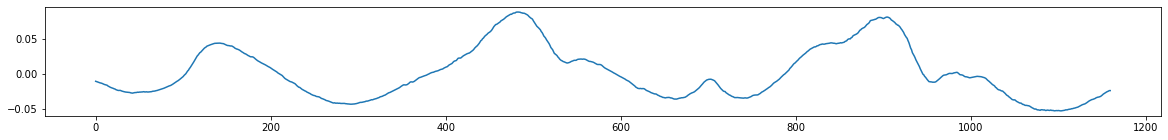

In [139]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

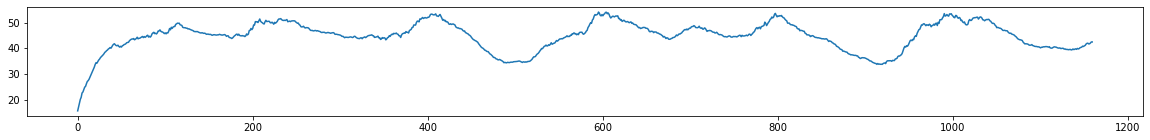

In [140]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [141]:
speeds.max()

54.09212

<BarContainer object of 10 artists>

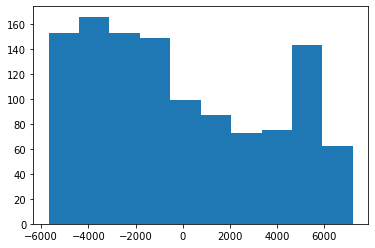

In [142]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

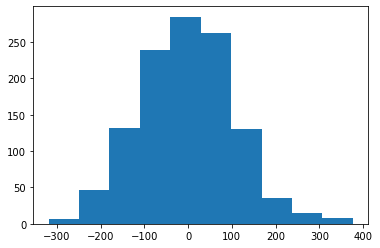

In [143]:
plt.hist(torque[1:]-torque[:-1])[2]

In [144]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [145]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    video.write(img)
    
video.release()

In [146]:
np.degrees(.18)

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


10.313240312354818

In [30]:
curve_prep_slowdown_time_sec = 1.0
headings = []
for i in range(len(targets)):
    traj, speed_mps = targets[i], kph_to_mps(aux[i, 2])
    future_heading = get_heading_at_dist_along_traj(traj, speed_mps*curve_prep_slowdown_time_sec)
    headings.append(future_heading)

/media/beans/ssd/bespoke/traj_utils.py:112: RuntimeWarning: invalid value encountered in arcsin
  heading = np.arcsin((next_wp_x - this_wp_x)/(next_wp_y - this_wp_y))


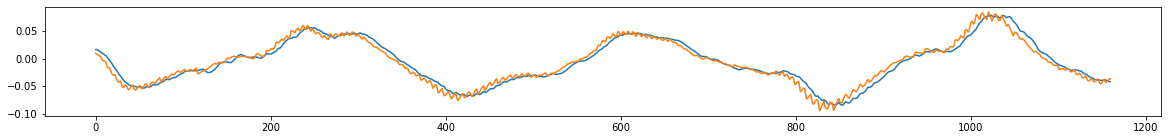

In [34]:
plt.figure(figsize=(20,2))
plt.plot(wp_angles)
plt.plot(np.array(headings)/2.6)

In [80]:
from viz_utils import make_vid

run_id = "sim"
model_stem = "6.19_avg"
make_vid(run_id, model_stem, img, aux)

RuntimeError: number of dims don't match in permute

In [4]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([11.358425 ,  5.107576 , 10.824746 ,  9.47597  ,  6.9628954,
        8.627792 , 11.552391 , 11.998904 ,  8.273651 ,  7.834757 ,
        9.251635 , 12.514745 ], dtype=float32)

In [7]:
all_aux = []
all_targets = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/media/beans/ssd/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in range(115, 1160, 116)]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        all_aux.append(aux)
        all_targets.append(targets)
        
all_aux = np.stack(all_aux, axis=0)
all_targets = np.stack(all_targets, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [172]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_targets[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

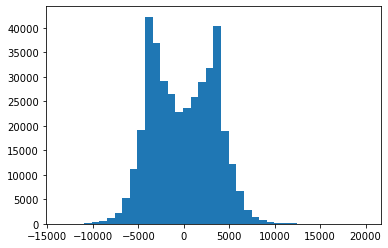

In [173]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

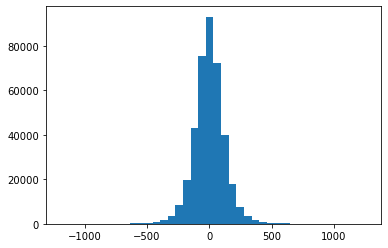

In [174]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [175]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(658.3597468758062, 10773.428598474078)

In [176]:
all_targets.shape

(338, 1160, 30)

In [177]:
mean_angles = abs(all_targets).mean(axis=0).mean(0)
mean_angles

array([0.01946773, 0.02140102, 0.02349101, 0.02566748, 0.02789374,
       0.03014976, 0.03242287, 0.03470305, 0.03698126, 0.03925293,
       0.04150908, 0.04374031, 0.04595105, 0.04814176, 0.05031391,
       0.0524782 , 0.05463824, 0.05679536, 0.05894962, 0.06110033,
       0.07178935, 0.08230626, 0.09259404, 0.10261779, 0.11234512,
       0.12176733, 0.13090506, 0.13977998, 0.14837137, 0.15667169],
      dtype=float32)

In [178]:
mean_angles[-1] / mean_angles[0]

8.047762

In [179]:
mean_angles[22] / mean_angles[0]

4.7562823

<BarContainer object of 40 artists>

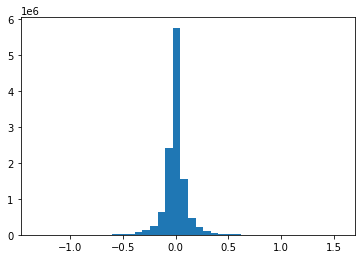

In [180]:
plt.hist(all_targets.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

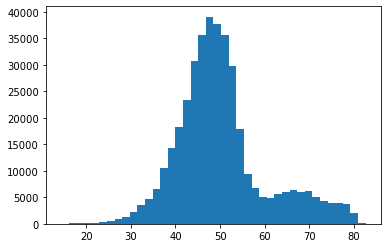

In [181]:
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

In [119]:
all_targets.min()

-1.3255545

In [ ]:
from scipy.signal import convolve2d
def smooth_targets(targets, window_size=4):
    # expects 3 dims, last is just padded
    smoothed = convolve2d(targets[:, :, 0], np.ones((1, window_size)), 'same') / window_size
    smoothed = np.expand_dims(smoothed, -1)
    return smoothed